# Solving the stochastic/rough Poisson equation

We aim to solve the Poisson equation in 1-D
$$
-\Delta u = f \quad \text{in} \quad(0, L) \\
u(x) = 0 \quad \text{for} \quad x = 0, L
$$

We will choose $u$ of the form:
$$
u = \sum_{n=1}^\infty a_n \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$

The functions 
$$
 \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$
form an orthonrmal basis of $L^2(0, L)$. Moreover 
$$
-\Delta  \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) =  \frac{n^2\pi^2}{L^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) = \lambda_n \sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big)
$$

In this way we have that 
$$
-\Delta u =  \sum_{n=1}^\infty a_n \frac{n^2\pi^2}{L^2}\sqrt{\frac{2}{L}}\sin\Big(\frac{n\pi x}{L}\Big) = f
$$
We will select the coefficients 
$$
a_n = \frac{\xi_n}{n^{\frac{2+ \frac{1}{2}}{2}}}  \quad \xi_n \sim \mathcal{N}(0,1) \; \text{i.i.d.}
$$
so that 
$$
||u||^2_{H^1} = \sum_{n=1}\frac{\xi^2_n}{n^{2 + \frac{1}{2}}}\lambda_n \propto \sum_{n=1}\frac{\xi^2_n}{n^{2 + \frac{1}{2}}}n^2 = \sum_{n=1}\frac{\xi^2_n}{n^\frac{1}{2}} < \infty \quad \text{a.s.}
$$
Therefore $f \in H^{-1}$ a.s.. In fact $u \in H^{1 + \frac{1}{4} -\delta}$ for any $\delta >0$ and so $f \in H^{-1 + \frac{1}{4} - \delta}$ for any $\delta >0$. 

In [22]:
import jax.numpy as jnp
from jax import random
from jax import scipy 

import matplotlib.pyplot as plt

In [23]:
# Define a functin to compute u

def evaluate_function(x, coef, L):
    values = 0
    for i, c in enumerate(coef):
        values +=c*jnp.sin((i+1)*jnp.pi*x/L)*jnp.sqrt(2/L)
    return values



In [24]:
# draw random values for the coefficients
key = random.PRNGKey(1)

n_coef = 1000
decay_u = 3# 1.25 # Regularity of u
L = 1 # Lenght of the domain
coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_f = coef_u*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2

x = jnp.linspace(0, L, 1200)
u_values = evaluate_function(x, coef_u, L=L)

f_values = evaluate_function(x, coef_f, L=L)

Text(0.5, 1.0, 'Function f')

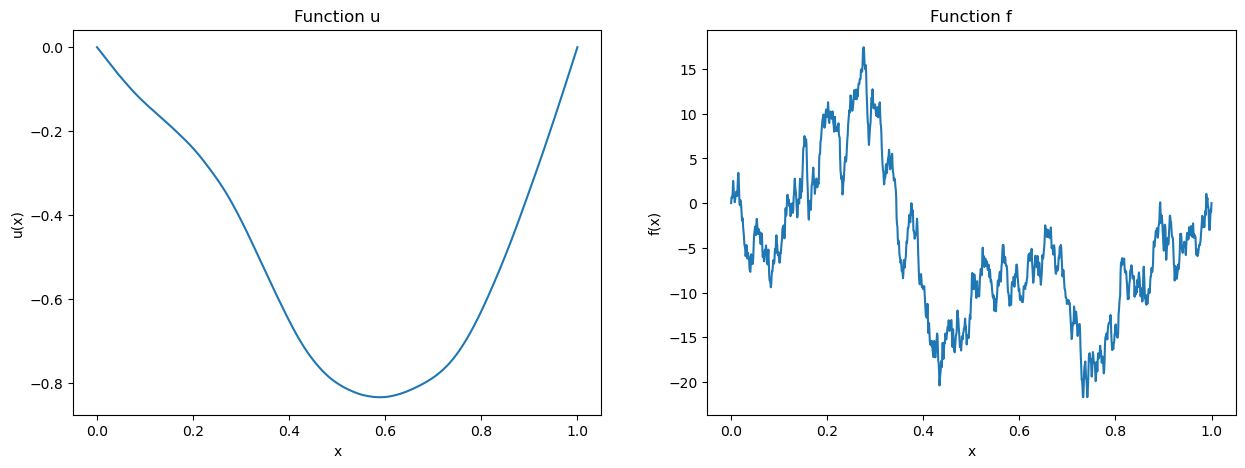

In [25]:
# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")


# Defining our weak measurements

In [26]:
import utils_rough_pde
from utils_rough_pde import *

In [27]:
epsilon_values =  jnp.array([0.01])

# Boundary of the domain
lower, upper = 0.0, 1.0

loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
vol = support[:,1] - support[:,0]
N_test_functions = loc_values.shape[0]

print("Number of test functions: ", N_test_functions)

Number of test functions:  50


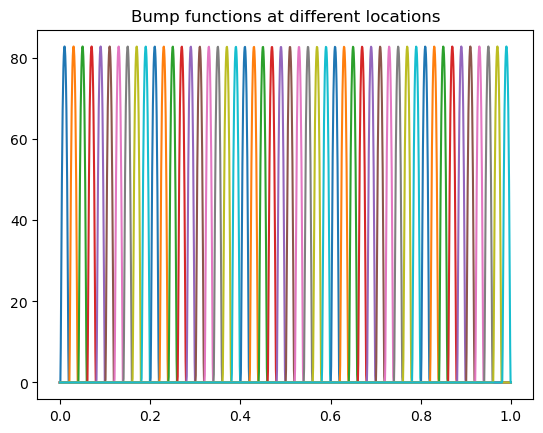

In [28]:
bump_values = vmap_bump(x, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(x, bump_values[:, 0, i])
plt.title("Bump functions at different locations")
plt.show()

In [29]:
from scipy.special import roots_legendre
n_order = 999
x_q, w_q = roots_legendre(n_order)
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)

# Construct the mmatrix of weighted bump functions 
psi_matrix = bump_vector(root_psi, epsilon_values, loc_values)
psi_matrix = psi_matrix * w_psi

## Computing the measurements of f

If f is highly oscillatory, then computing it's value against a test function will not be accurate unless our quadrature is very fine. Therefore we cheat and compute the measurements in the following way:

$$
\int_{\Omega} f \psi = \sum_{n=1} a_n \frac{n^2\pi^2}{L^2}\sqrt{\frac{2}{L}} \int_{\Omega} \sin\Big(\frac{n\pi x}{L}\Big) \psi(x)dx
$$

Hence the quarature is accurate as long as the integration against the sin functions is a accurate. A similar trick can be used for $u$ (although we do not need it in our case).

In [30]:
# Integrate the RHS against the bump functions (this is doing the naive quadrature)
@jit
def integrate_f_test_functions(f_values, psi):
    # Psi should be a matrix containing the values of the weighted test functions at the quadrature points
    return f_values.T@psi

vmap_integrate_f_test_functions = jit(vmap(integrate_f_test_functions, in_axes=(0,0)))

In [32]:
f_quad = evaluate_function(root_psi, coef_f, L)

# Checking that the nodal values are correct
for i in range(f_quad.shape[0]):
    assert jnp.allclose(f_quad[i],  evaluate_function(root_psi[i], coef_f, L))

f_meas_naive = vmap_integrate_f_test_functions(f_quad, psi_matrix)

# Checking that the measurements are correct
for i in range(f_meas.shape[0]):
    assert jnp.allclose(f_meas_naive[i],  integrate_f_test_functions(f_quad[i], psi_matrix[i]))

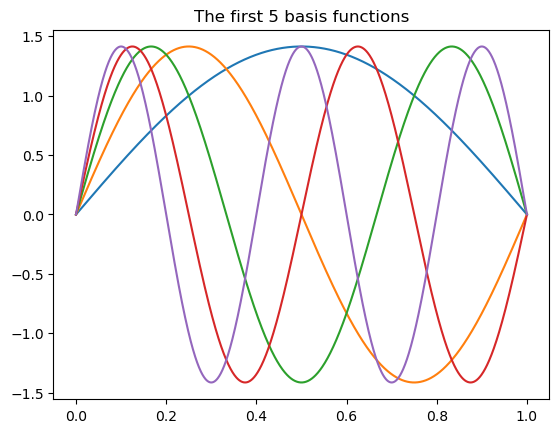

In [33]:
def evaluate_basis(x, n):
    return jnp.sin((n)*jnp.pi*x/L)*jnp.sqrt(2/L)

for i in range(5):
    plt.plot(x, evaluate_basis(x, i+1))
plt.title("The first 5 basis functions")
plt.show()

In [34]:
basis_quad = []
for i in range(n_coef):
    basis_quad.append(evaluate_basis(root_psi, i+1))

basis_quad = jnp.array(basis_quad)
basis_test =  jnp.einsum('nmk,mk->nm',  basis_quad, psi_matrix)
f_meas= jnp.sum(coef_f[:, None]*basis_test, axis = 0)
print(f_meas.shape)

(50,)


In [35]:
print("Error between the naive and better measurement: ", jnp.linalg.norm(f_meas - f_meas_naive))

Error between the naive and better measurement:  8.541434657071037e-14


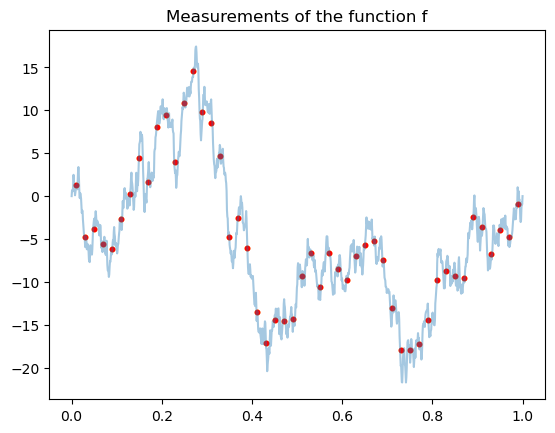

In [36]:
plt.figure()
plt.plot(x, f_values, label="True function", alpha = 0.4)
plt.scatter(loc_values, f_meas_naive, s = 10, label = "Quadrature measurements", color = "Orange")
plt.scatter(loc_values, f_meas, s = 10, label = "Quadrature measurements", color = "Red")
plt.title("Measurements of the function f")

plt.show()

In [37]:
u_quad = evaluate_function(root_psi, coef_u, L)
u_meas = vmap_integrate_f_test_functions(u_quad, psi_matrix)

print("These values should be pretty close")
for i in range(u_meas.shape[0]):
    print(u_meas[i], evaluate_function(loc_values[i], coef_u, L))

These values should be pretty close
-0.014700818839719045 -0.01469311618169955
-0.044232317373953486 -0.04427253485864509
-0.07220531133986818 -0.07223141048621338
-0.09838032481487448 -0.09842457578612097
-0.12233144951431302 -0.12237956814010481
-0.1437921113496591 -0.1438148083899429
-0.16414059032984454 -0.1641368381335091
-0.18457017870957204 -0.18453099200328796
-0.20611233397310366 -0.2060932456198894
-0.22861299032862725 -0.2285440766675062
-0.2539895111801854 -0.25391338529290636
-0.2829959758396219 -0.28297184308139844
-0.3143366634752203 -0.3142493371385178
-0.34962773303199346 -0.34951337937350285
-0.39032872473663577 -0.39025474160096485
-0.43545097325999826 -0.43537644810585263
-0.4836983506960466 -0.4836603018899651
-0.5334060030016469 -0.5334466909727191
-0.5818109575483477 -0.5818289080257014
-0.6287606854512244 -0.6288094397703651
-0.6732433292393296 -0.6733488018656005
-0.7124799797817967 -0.7126106274937781
-0.7450300799304524 -0.7451430346217502
-0.7715082944229169

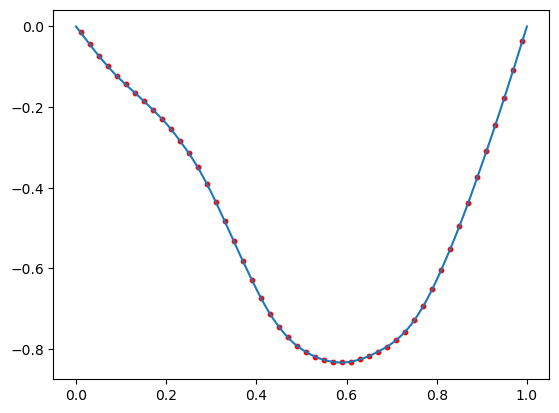

In [38]:
plt.plot(x, u_values, label="True function")
plt.scatter(loc_values, u_meas, s = 10, label="Measurements", color = "red")

# Solving the Poisson equation

To solve the Poisson equation, we solve the following linear system
$$
\Theta \bold{c} = Y
$$
where 
$$
Y = \begin{bmatrix}
\bold{0} \\
[f, \psi]
\end{bmatrix}
$$
and
$$
\Theta = \begin{bmatrix}
K(X_{\partial\Omega},X_{\partial\Omega}) &  -\Delta_y K(X_{\partial\Omega}, \boldsymbol{\psi}) \\
-\Delta_y K( X_{\partial\Omega}, \boldsymbol{\psi})^\intercal & \Delta_x\Delta_y K( \boldsymbol{\psi}, \boldsymbol{\psi})
\end{bmatrix}
$$

The resulting function is given by 
$$
\begin{pmatrix}
K(\cdot \;,  X_{\partial\Omega}),  -\Delta_y K(\cdot \;, \boldsymbol{\psi})
\end{pmatrix}\bold{c}
$$

In [39]:
# We define the kernel function to be a Squared Exponential kernel. The only parameter to be defined is the lengthscale l
length_scale = 0.05


theta_22 = construct_theta_integral(psi_matrix, root_psi, length_scale)
theta_22.shape

(50, 50)

In [40]:
boundary = jnp.array([[lower, upper]]).T
theta_11 = vmap_kernel(boundary, boundary, length_scale)
theta_11.shape, theta_11

((2, 2),
 Array([[1.00000000e+00, 1.38389653e-87],
        [1.38389653e-87, 1.00000000e+00]], dtype=float64))

In [44]:
# Now we compute the kernel matrix between the measurements and the boundary

kernel_vmap1 = jit(vmap(neg_laplacian_y, in_axes=(None, 0, None)))
vmap_kernel_quad = jit(vmap(vmap(kernel_vmap1, in_axes=(None, 0, None)), in_axes=(0,None, None)))

K_quad = vmap_kernel_quad(boundary, root_psi[:, :, None], length_scale)
print(K_quad.shape)

# K_quad = compute_K_pairwise(boundary[0], root_psi.T, length_scale).T
# print(K_quad.shape)

#Check that the kernel matrix is correct (this is a bit slow)
for i in range(K_quad.shape[0]):
    for j in range(K_quad.shape[1]):
        for l in range(K_quad.shape[2]):
            assert jnp.allclose(K_quad[i, j, l], neg_laplacian_y(boundary[i], root_psi[j, l], length_scale))


(2, 50, 999)


In [45]:
# Compute the upper right block of the kernel matrix

theta_12 = jnp.einsum('nmk,mk->nm', K_quad, psi_matrix) # this was given by chat gpt
print(theta_12.shape)

# Check that the kernel matrix is correct 
for i in range(theta_12.shape[0]):
    for j in range(theta_12.shape[1]):
        assert jnp.allclose(theta_12[i, j], K_quad[i, j]@psi_matrix[j])

(2, 50)


In [46]:
# Construct the kernel matrix
theta = jnp.block([[theta_11, theta_12], [theta_12.T, theta_22]])

# Check that the kernel matrix is positive definite
eigval, eigvec = scipy.linalg.eigh(theta)
jnp.min(eigval) # This should be positive (or a very small negative number)

Array(0.00059737, dtype=float64)

In [47]:
def construct_theta(boundary,psi_matrix, root_psi, length_scale):
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_22 = construct_theta_integral(psi_matrix, root_psi, length_scale)

    K_quad = vmap_kernel_quad(boundary, root_psi[:, :, None], length_scale)
    theta_12 = jnp.einsum('nmk,mk->nm', K_quad, psi_matrix)
    

    theta = jnp.block([[theta_11, theta_12], [theta_12.T, theta_22]])

    return theta
    
theta = construct_theta(boundary,psi_matrix, root_psi, length_scale)

In [48]:
# Construct the RHS of the linear system
Y = jnp.block([jnp.zeros(shape = 2), f_meas])
Y.shape

(52,)

In [49]:
nugget_interior = 1e-5
nugget_boundary = 1e-10

nugget = jnp.block([nugget_boundary*jnp.ones(shape = 2), nugget_interior*jnp.ones(shape = N_test_functions)])
print(nugget.shape)
c = scipy.linalg.solve(theta + nugget*jnp.eye(theta.shape[0]), Y, assume_a='pos')
print(c.shape)

(52,)
(52,)


In [50]:
def evaluate_prediction(x, c, length_scale):
    K_boundary = vmap_kernel(x,boundary, length_scale)
    K_interior = jnp.einsum('nmk,mk->nm',  vmap_kernel_quad(x, root_psi[:, :, None], length_scale), psi_matrix)
    K_evaluate = jnp.block([[K_boundary, K_interior]])

    return K_evaluate@c

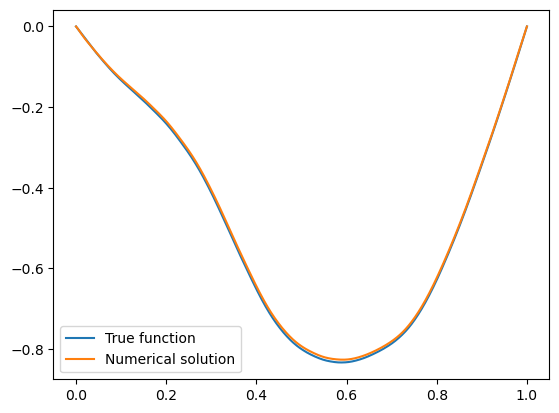

In [51]:
pred = evaluate_prediction(x, c, length_scale)

plt.plot(x, u_values, label="True function")
plt.plot(x, pred, label="Numerical solution")
plt.legend()


In [52]:
def compute_error(c, coef_u, length_scale):
    x_q_error, w_q_error =  vmap_root_interval(x_q, w_q, jnp.array([0,L])[None])
    x_q_error = jnp.squeeze(x_q_error)
    w_q_error = jnp.squeeze(w_q_error)
    pred_quad =evaluate_prediction(x_q_error, c, length_scale)
    u_quad = evaluate_function(x_q_error, coef_u, L=L)

    loss = jnp.sqrt((pred_quad - u_quad)**2@w_q_error)
    relative_loss = loss/jnp.sqrt(u_quad**2@w_q_error)

    return loss, relative_loss

In [53]:
# Computing the error between the true solution and the numerical solution

loss, relative_loss = compute_error(c, coef_u, length_scale)
print("L^2 error: ", loss)
print("Relative L^2 error: ", relative_loss)

L^2 error:  0.0055042667349102575
Relative L^2 error:  0.009826421768541007


# Observing the convergence rates

In [54]:
n_meas_list = jnp.arange(10, 70, 10, dtype=int)
# Boundary of the domain
lower, upper = 0.0, 1.0
length_scale = 0.05
boundary = jnp.array([[lower, upper]]).T

nugget_interior = 1e-5
nugget_boundary = 1e-10

In [55]:
error_list = []
relative_error_list = []

pred_list = []
for n_meas in n_meas_list:

    # Construct the measurements
    epsilon_values =  jnp.array([1/(n_meas*2)])
    loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
    support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
    vol = support[:,1] - support[:,0]
    N_test_functions = loc_values.shape[0]

    print("Number of test functions: ", N_test_functions)

    # Construct the mmatrix of weighted bump functions 
    root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
    psi_matrix = bump_vector(root_psi, epsilon_values, loc_values)
    psi_matrix = psi_matrix * w_psi

    # # Construct our measurements of the basis functions
    # basis_quad = []
    # for i in range(n_coef):
    #     basis_quad.append(evaluate_basis(root_psi, i+1))
    # basis_quad = jnp.array(basis_quad)
    # # Construct our measurements of the RHS
    # basis_test =  jnp.einsum('nmk,mk->nm',  basis_quad, psi_matrix)
    # f_meas= jnp.sum(coef_f[:, None]*basis_test, axis = 0)
    f_quad = evaluate_function(root_psi, coef_f, L)
    f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

    # Construct the RHS of the linear system
    Y = jnp.block([jnp.zeros(shape = 2), f_meas])

    # Compute the kernel matrix
    print("Constructing the kernel matrix")
    theta = construct_theta(boundary,psi_matrix, root_psi, length_scale)

    # Construct the nugget
    nugget = jnp.block([nugget_boundary*jnp.ones(shape = 2), nugget_interior*jnp.ones(shape = N_test_functions)])

    # Solve the linear system
    print("Solving the linear system")
    c = scipy.linalg.solve(theta + nugget*jnp.eye(theta.shape[0]), Y, assume_a='pos')

    # Compute the error between the true solution and the numerical solution
    loss, relative_loss = compute_error(c, coef_u, length_scale)
    error_list.append(loss)
    relative_error_list.append(relative_loss)

    # Compute the numerical solution
    pred = evaluate_prediction(x, c, length_scale)
    pred_list.append(pred)




Number of test functions:  10
Constructing the kernel matrix
Solving the linear system
Number of test functions:  20
Constructing the kernel matrix
Solving the linear system
Number of test functions:  30
Constructing the kernel matrix
Solving the linear system
Number of test functions:  40
Constructing the kernel matrix
Solving the linear system
Number of test functions:  50
Constructing the kernel matrix
Solving the linear system
Number of test functions:  60
Constructing the kernel matrix
Solving the linear system


In [56]:
f_quad

Array([[ 2.35831820e-05,  1.24258125e-04,  3.05379021e-04, ...,
         1.28007041e+00,  1.27974521e+00,  1.27956444e+00],
       [ 1.27947975e+00,  1.27929897e+00,  1.27897373e+00, ...,
        -6.10517458e+00, -6.10540769e+00, -6.10553723e+00],
       [-6.10559791e+00, -6.10572742e+00, -6.10596036e+00, ...,
        -2.62005657e+00, -2.62008478e+00, -2.62010048e+00],
       ...,
       [-3.52368172e+00, -3.52369898e+00, -3.52373000e+00, ...,
        -3.81793271e+00, -3.81808448e+00, -3.81816887e+00],
       [-3.81820841e+00, -3.81829283e+00, -3.81844476e+00, ...,
        -1.73207984e+00, -1.73186985e+00, -1.73175316e+00],
       [-1.73169850e+00, -1.73158185e+00, -1.73137204e+00, ...,
        -5.29818821e-04, -2.15582242e-04, -4.09157571e-05]],      dtype=float64)

In [57]:
coef_f

Array([-5.36166437e+00,  5.32819444e+00,  1.12887757e+00,  8.18761599e-01,
       -2.68166203e+00, -3.93347154e+00,  6.16635036e-02,  4.21209197e-01,
       -2.36443692e-01,  3.78013867e-01, -1.34841203e+00,  1.40126568e-01,
        3.76660710e-01, -6.14320849e-01,  1.31090836e-01,  8.70878060e-01,
       -1.14253390e-01,  2.53531613e-01, -4.20252457e-01, -2.00368259e-01,
        1.91605555e-01,  3.41130607e-01,  4.68353520e-01, -1.30786780e-01,
       -3.41245823e-02, -4.91344539e-01,  4.56938170e-02, -1.33478112e-01,
       -4.09844762e-01, -1.52658364e-01,  5.60055059e-02,  9.51566597e-01,
        1.86079844e-01,  7.70243722e-02, -3.08003358e-01, -4.66693823e-02,
        5.60533680e-02, -3.94879038e-02,  2.95363989e-01,  2.84677891e-01,
        9.47137574e-02,  2.40781791e-01,  5.16824665e-01,  1.33235165e-01,
        9.89148039e-02, -1.10954113e-01,  2.58835076e-03,  1.01133891e-02,
        2.57746614e-01,  1.24661713e-01, -1.35935434e-01, -1.94743128e-01,
        5.66321757e-02,  

In [58]:
Y

Array([  0.        ,   0.        ,   1.07450597,  -2.78938051,
        -6.41380803,  -3.37447743,  -6.26165719,  -5.61720688,
        -3.33699184,  -0.44112609,   0.53759504,   3.19008942,
         2.28454287,   8.83473166,   9.63674564,   6.42306364,
         7.1180413 ,  11.98085049,  15.66190546,  10.0610332 ,
         9.52144146,   4.19241154,   1.05773612,  -6.98683374,
        -1.47216625,  -6.93233737, -12.81065416, -16.22788273,
       -16.58218282, -14.22958929, -14.56026519, -14.36144641,
        -9.17131552,  -6.58238751,  -9.09708863,  -8.50576259,
        -8.54867976,  -8.1533996 , -10.091003  ,  -6.618177  ,
        -7.54610839,  -3.39155905,  -6.529471  ,  -8.06424066,
       -13.08840178, -15.30747781, -19.06758224, -18.15447805,
       -17.14424888, -14.64452748, -10.93400528,  -8.98268143,
        -9.241535  ,  -9.68970006,  -7.69713392,  -2.08023052,
        -3.90434493,  -7.26667134,  -4.76272148,  -3.2047471 ,
        -4.43596843,  -0.77978567], dtype=float64)

In [59]:
error_list

[Array(0.55808515, dtype=float64),
 Array(0.02454831, dtype=float64),
 Array(0.00382052, dtype=float64),
 Array(0.00767764, dtype=float64),
 Array(0.00550427, dtype=float64),
 Array(0.00644008, dtype=float64)]

In [60]:
pred_list

[Array([-1.50080035e-13, -1.03409054e-04, -2.08590783e-04, ...,
        -5.72694050e-04, -2.86813409e-04,  5.11190049e-13], dtype=float64),
 Array([ 1.54890101e-10, -1.25357985e-03, -2.46939545e-03, ...,
        -5.80433827e-03, -2.91926979e-03,  1.96565320e-10], dtype=float64),
 Array([ 1.66383352e-10, -1.16806816e-03, -2.33939071e-03, ...,
        -5.81382221e-03, -2.90208564e-03,  2.08982831e-10], dtype=float64),
 Array([ 1.75062187e-10, -1.25080808e-03, -2.51681018e-03, ...,
        -5.88465833e-03, -2.94053709e-03,  2.08543072e-10], dtype=float64),
 Array([ 3.98358679e-10, -1.07203860e-03, -2.20703030e-03, ...,
        -6.15758433e-03, -3.11630094e-03, -6.18456397e-11], dtype=float64),
 Array([-6.51925802e-09, -1.73173565e-03, -3.11518461e-03, ...,
        -6.01760940e-03, -3.00839524e-03,  6.37101039e-10], dtype=float64)]

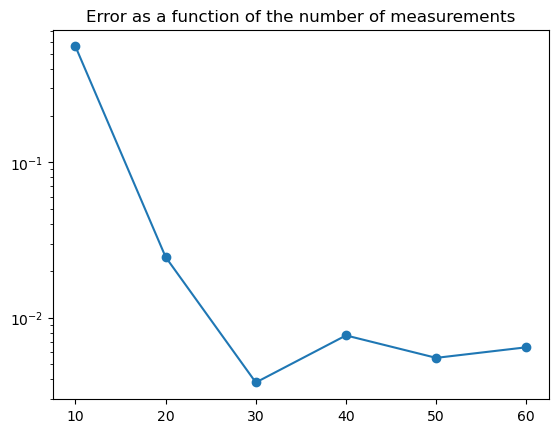

In [61]:
plt.plot(n_meas_list, error_list, label="L^2 error")
plt.scatter(n_meas_list, error_list)
plt.title("Error as a function of the number of measurements")
plt.yscale("log")

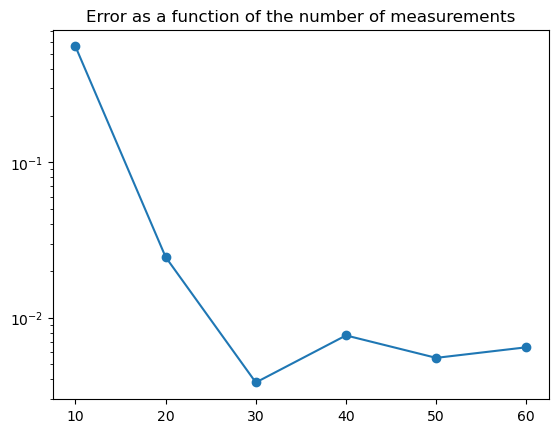

In [62]:
plt.plot(n_meas_list, error_list, label="L^2 error")
plt.scatter(n_meas_list, error_list)
plt.title("Error as a function of the number of measurements")
plt.yscale("log")

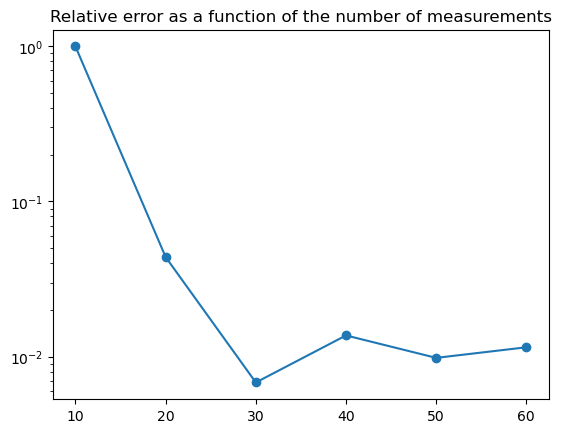

In [63]:
plt.plot(n_meas_list, relative_error_list, label="Relative L^2 error")
plt.scatter(n_meas_list, relative_error_list)
plt.title("Relative error as a function of the number of measurements")
plt.yscale("log")

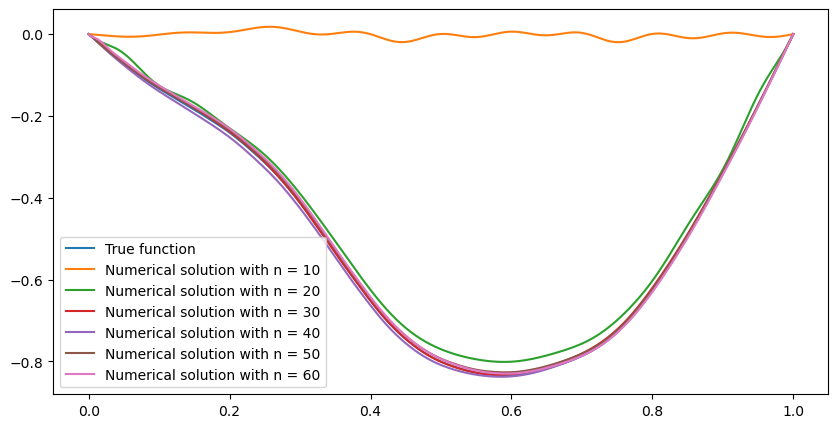

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(x, u_values, label="True function")
for i, pred in enumerate(pred_list):
    plt.plot(x, pred, label="Numerical solution with n = {}".format(n_meas_list[i]))

plt.legend()
plt.show()